### Analisis Finanzas 
#### Segundo desafio
¿Los clientes con préstamos e hipotecas tienden a tener un saldo medio más bajo o más riesgo de incumplimiento? ¿Cómo deberíamos ajustar nuestras ofertas y estrategias de gestión de riesgos en función de estos hallazgos?

#### Librerias y más

In [2]:
"""Librerías que pueden ser necesarias"""

# Manejo de datos
import pandas as pd                 # Análisis y manipulación de datos en tablas
import numpy as np                  # Cálculos numéricos y matrices
import os                           # Gestión de rutas de archivos
import re                           # Expresiones regulares para búsqueda y manipulación de texto

# Visualización de datos
import matplotlib.pyplot as plt     # Gráficos básicos en 2D
import seaborn as sns               # Gráficos estadísticos mejorados
import plotly.express as px         # Gráficos interactivos simplificados
import plotly.graph_objects as go   # Control avanzado de gráficos en Plotly
import plotly.io as pio             # Interfaz de entrada/salida de Plotly
import squarify                     # Visualización de diagramas de "treemap"

# Procesado y análisis
from scipy import stats
from scipy.stats import chi2_contingency # Pruebas de hipótesis y análisis estadístico
#Paleta de colores oficial
custom_palette = ["#2E2F36", "#5F6F81", "#AABBC8", "#DCE3EA", "#2CCED1"]

#### Carga de datos

In [3]:
df = pd.read_csv('../Data/df_250519.csv')

In [11]:
df.head()

,Unnamed: 0,id,age,job,marital,education,default,balance,housing,loan,...,day,month,duration,campaign,pdays,previous,poutcome,deposit,date,saldo_bin
0,0,1,59,admin.,married,secondary,False,2343,True,False,...,5,May,1042,1,-1,0,unknown,True,2024-05-05,"(1958.1, 10763.2]"
1,1,2,59,admin.,married,secondary,False,2343,True,False,...,5,May,1042,1,-1,0,unknown,True,2024-05-05,"(1958.1, 10763.2]"
2,2,3,56,admin.,married,secondary,False,45,False,False,...,5,May,1467,1,-1,0,unknown,True,2024-05-05,"(-6935.051, 1958.1]"
3,3,4,41,technician,married,secondary,False,1270,True,False,...,5,May,1389,1,-1,0,unknown,True,2024-05-05,"(-6935.051, 1958.1]"
4,4,5,55,services,married,secondary,False,2476,True,False,...,5,May,579,1,-1,0,unknown,True,2024-05-05,"(1958.1, 10763.2]"


#### Tabla relacion Prestamos e hipotecas
Se analiza si tiene prestamo, si tiene hipoteca, Saldo medio y tasa de incumplimiento

   Tiene préstamo  Tiene hipoteca  Saldo medio  Tasa incumplimiento  \
0           False           False  1844.047228             0.008864   
1           False            True  1365.205982             0.013876   
2            True           False   801.467991             0.057395   
3            True            True   773.169967             0.026403   

   Número de clientes  
0                7559  
1                6486  
2                 906  
3                1212  


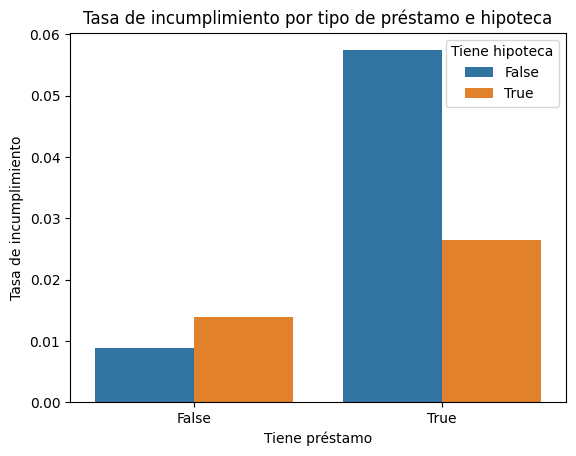

In [4]:
Tabla_agrupada = df.groupby(['loan', 'housing']).agg({'balance': 'mean','default': 'mean','id': 'count'}).reset_index()
Tabla_agrupada.columns = ['Tiene préstamo', 'Tiene hipoteca', 'Saldo medio', 'Tasa incumplimiento', 'Número de clientes'] 
print(Tabla_agrupada)

'''Este grafico se puede cambiar de orden para mostrar lade manera inversa 
prestamo como Hue y hipoteca como x'''

sns.barplot(data=Tabla_agrupada, x='Tiene préstamo', y='Tasa incumplimiento', hue='Tiene hipoteca')
plt.title("Tasa de incumplimiento por tipo de préstamo e hipoteca")
plt.ylabel("Tasa de incumplimiento")
plt.show()

<Axes: xlabel='Tiene hipoteca', ylabel='Saldo medio'>

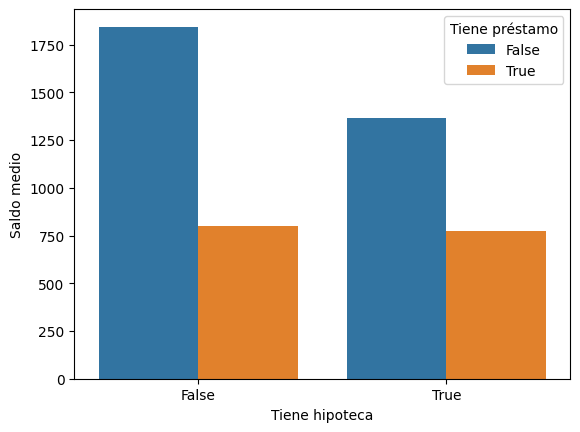

In [8]:
sns.barplot(data=Tabla_agrupada, x='Tiene hipoteca', y='Saldo medio', hue='Tiene préstamo')

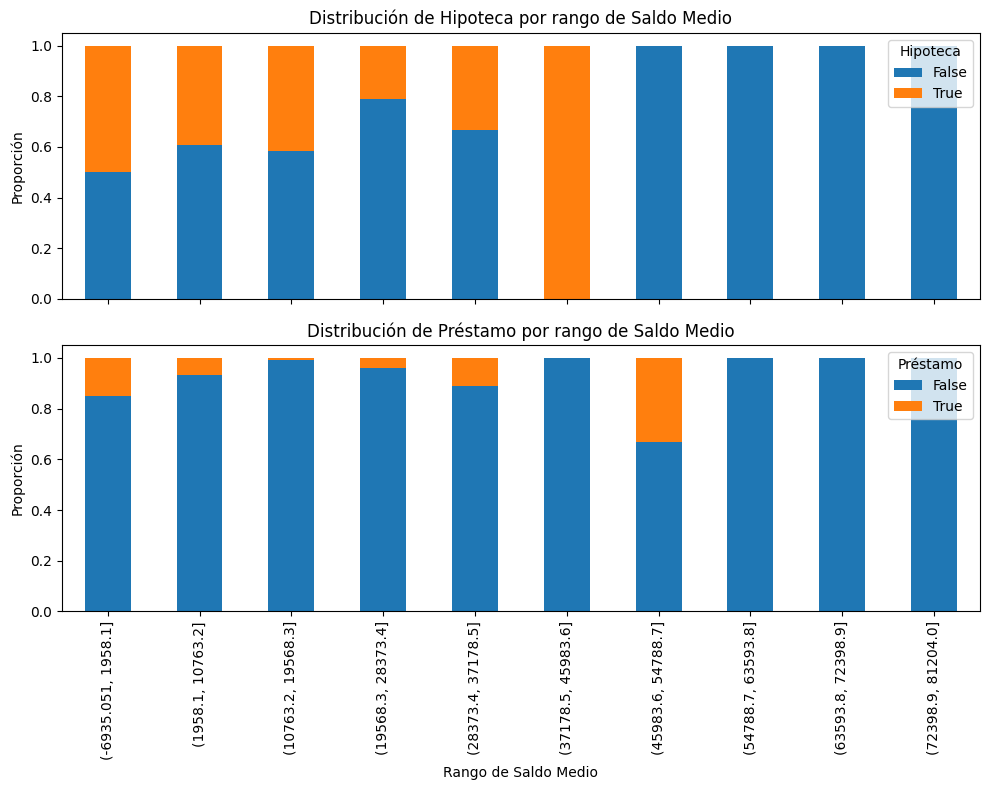

In [10]:
# Crear una variable de bins de saldo medio
df['saldo_bin'] = pd.cut(df['balance'], bins=10)

# Calcular proporciones de préstamo e hipoteca por bin de saldo
pivot_housing = pd.crosstab(df['saldo_bin'], df['housing'], normalize='index')
pivot_loan = pd.crosstab(df['saldo_bin'], df['loan'], normalize='index')

# Crear el gráfico de subplots apilados
fig, axes = plt.subplots(nrows=2, figsize=(10, 8), sharex=True)

# Hipoteca en eje Y superior
pivot_housing.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title("Distribución de Hipoteca por rango de Saldo Medio")
axes[0].set_ylabel("Proporción")
axes[0].legend(title="Hipoteca")

# Préstamo en eje Y inferior
pivot_loan.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title("Distribución de Préstamo por rango de Saldo Medio")
axes[1].set_ylabel("Proporción")
axes[1].set_xlabel("Rango de Saldo Medio")
axes[1].legend(title="Préstamo")

plt.tight_layout()
plt.show()


### Razon de monomios
chances de incumplimiento al tener un prestamo o hipoteca
La razón de momios (odds ratio) se calcula así:
odds ratio = odds (evento) / odds (no evento) donde evento puede ser tanto prestamo como hipoteca
odds (evento) = p (evento) / (1 - p (evento))

In [6]:
def odds_ratio(df, column_a, column_b):
    """Calcula la razón de probabilidades (odds ratio) entre dos grupos."""
    tabla_contingencia = pd.crosstab(df[column_a],df[column_b] )
    A= tabla_contingencia.iloc[0, 0]
    B= tabla_contingencia.iloc[0, 1] 
    C= tabla_contingencia.iloc[1, 0]
    D= tabla_contingencia.iloc[1, 1]
    # Evitar divisiones por cero
    if B == 0 or D == 0:
        print("⚠️ Uno de los valores es cero, no se puede calcular la razón de momios.")
        return None
    odds_sin_evento = A / B
    odds_con_evento = C / D
    odds_ratio = odds_con_evento / odds_sin_evento
    print(f"📊 Tabla de contingencia entre '{column_a}' y '{column_b}':\n{tabla_contingencia}\n")
    print(f"odds_sin_{column_a}: {odds_sin_evento}")
    print(f"odds_con_{column_a} : {odds_con_evento}")
    print(f"odds_ratio: {odds_ratio}")
    
# aplicar la función a los datos
odds_ratio(df, 'loan', 'default')
odds_ratio(df, 'housing', 'default')


📊 Tabla de contingencia entre 'loan' y 'default':
default  False  True 
loan                 
False    13888    157
True      2034     84

odds_sin_loan: 88.45859872611464
odds_con_loan : 24.214285714285715
odds_ratio: 0.2737358048057933
📊 Tabla de contingencia entre 'housing' y 'default':
default  False  True 
housing              
False     8346    119
True      7576    122

odds_sin_housing: 70.1344537815126
odds_con_housing : 62.09836065573771
odds_ratio: 0.8854187536583737


### Chi cuadrado
comprobar la relaciond variables categoricas

In [7]:
# Función para ejecutar Chi-cuadrado entre default y una variable categórica
def Funcion_Chi2(df, column):
    Tabla_contingencia = pd.crosstab(df[column], df['default'])
    chi2, p, dof, expected = chi2_contingency(Tabla_contingencia)
    print(f"\nTest Chi-cuadrado entre '{column}' y 'default'")
    print("Tabla de contingencia:\n", Tabla_contingencia)
    print(f"Chi2 = {chi2:.4f}, p-valor = {p:.4f}, grados de libertad = {dof}")
    if p < 0.05:
        print("❗Hay evidencia estadística de asociación entre las variables.")
    else:
        print("✅ No se detecta asociación estadísticamente significativa.")

# Aplicar a 'loan' y 'housing'
Funcion_Chi2(df, 'loan')
Funcion_Chi2(df, 'housing')


Test Chi-cuadrado entre 'loan' y 'default'
Tabla de contingencia:
 default  False  True 
loan                 
False    13888    157
True      2034     84
Chi2 = 99.7154, p-valor = 0.0000, grados de libertad = 1
❗Hay evidencia estadística de asociación entre las variables.

Test Chi-cuadrado entre 'housing' y 'default'
Tabla de contingencia:
 default  False  True 
housing              
False     8346    119
True      7576    122
Chi2 = 0.7622, p-valor = 0.3826, grados de libertad = 1
✅ No se detecta asociación estadísticamente significativa.


# KPIs

- saldo medio gral
- saldo medio por decil
- % clientes por tsa de riesgo
- % clientes con hipoteca
- % clientes con préstamo
- tasa incumplimiento
- tasa contratación depósito